In [1]:
import math
import random

import gym
from custom_cartpoleswingup import CartPoleSwingUpEnv
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from sac import SoftActorCritic
from sac import PolicyNetwork
from model_learning import ModelOptim, Model
from mppi import MPPI

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return actions

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
def plot(frame_idx, rewards):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [6]:
# env = gym.make("LunarLanderContinuous-v2")
# env = CartPoleSwingUpEnv()
env = NormalizedActions(gym.make("Pendulum-v0"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 128

policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim)

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

sac = SoftActorCritic(policy=policy_net, 
                      state_dim=state_dim, 
                      action_dim=action_dim, 
                      replay_buffer=replay_buffer)

model = Model(state_dim, action_dim)
model_optim = ModelOptim(model, replay_buffer, lr=1e-2)

planner = MPPI(model, policy_net)

In [7]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

In [8]:
max_frames  = 40000

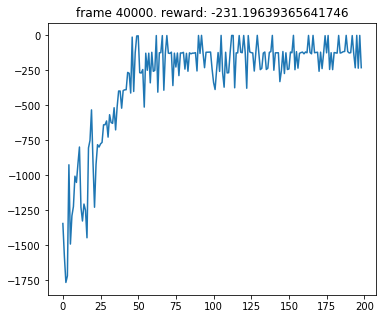

In [9]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
#         action = policy_net.get_action(state)
        action = planner(state)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            sac.soft_q_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        env.render()
        
        if frame_idx % 1000 == 0:
            clear_output(True)

            plot(frame_idx, rewards)
#             plot(frame_idx, model_optim.log['loss'])
        
        if done:
            break
    if len(replay_buffer) > 128:
        model_optim.update_model(128, mini_iter=10)

        
    rewards.append(episode_reward)

In [36]:
model_optim = ModelOptim(model, replay_buffer, lr=1e-5)

In [37]:
model_optim.update_model(256, mini_iter=500)

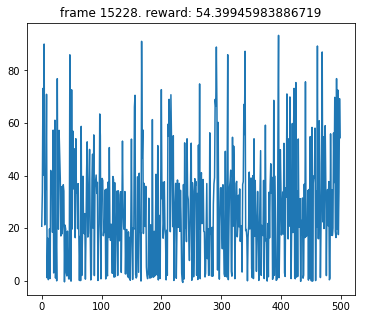

In [38]:
plot(frame_idx, model_optim.log['loss'])


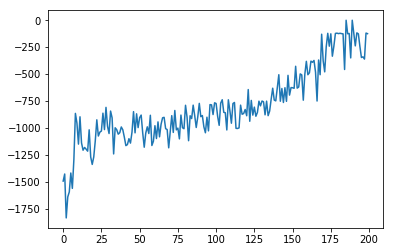

In [10]:
plt.plot(rewards)

In [10]:
60*500

30000